In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [5]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, last_tune_log, tune, Verbosity
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "014"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(436, 72, 92, 436)

In [ ]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.05
wandb.config["kl_coef"] = kl_coef = 0.01

expected_tokens = 4000  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 5e-4
model = models.qwen_32b()
model.tune_max_batch_tokens *= 2
wandb.config["model"] = model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 64
wandb.config["seq_len"] = seq_len = 16384 // 2
wandb.config["stride"] = stride = 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 8
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-32B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --port=8000 --api-key=default
INFO 02-19 16:10:12 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 16:10:14 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 16:10:14 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-32B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.47it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.43it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.42it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:03<00:02,  1.42it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:04<00:01,  1.40it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.39it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.69it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.52it/s]



INFO 02-19 16:11:42 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=14001) INFO 02-19 16:11:42 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=14000) INFO 02-19 16:11:43 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=14002) INFO 02-19 16:11:43 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=14001) INFO 02-19 16:11:49 worker.py:267] Memory profiling takes 5.95 seconds
(VllmWorkerProcess pid=14001) INFO 02-19 16:11:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=14001) INFO 02-19 16:11:49 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.16GiB.
(VllmWorkerProcess pid=14000) INFO 02-19 16:11:49 worker.py:267] Memory profiling takes 5

INFO:     Started server process [13639]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-19 16:12:50 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44420 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


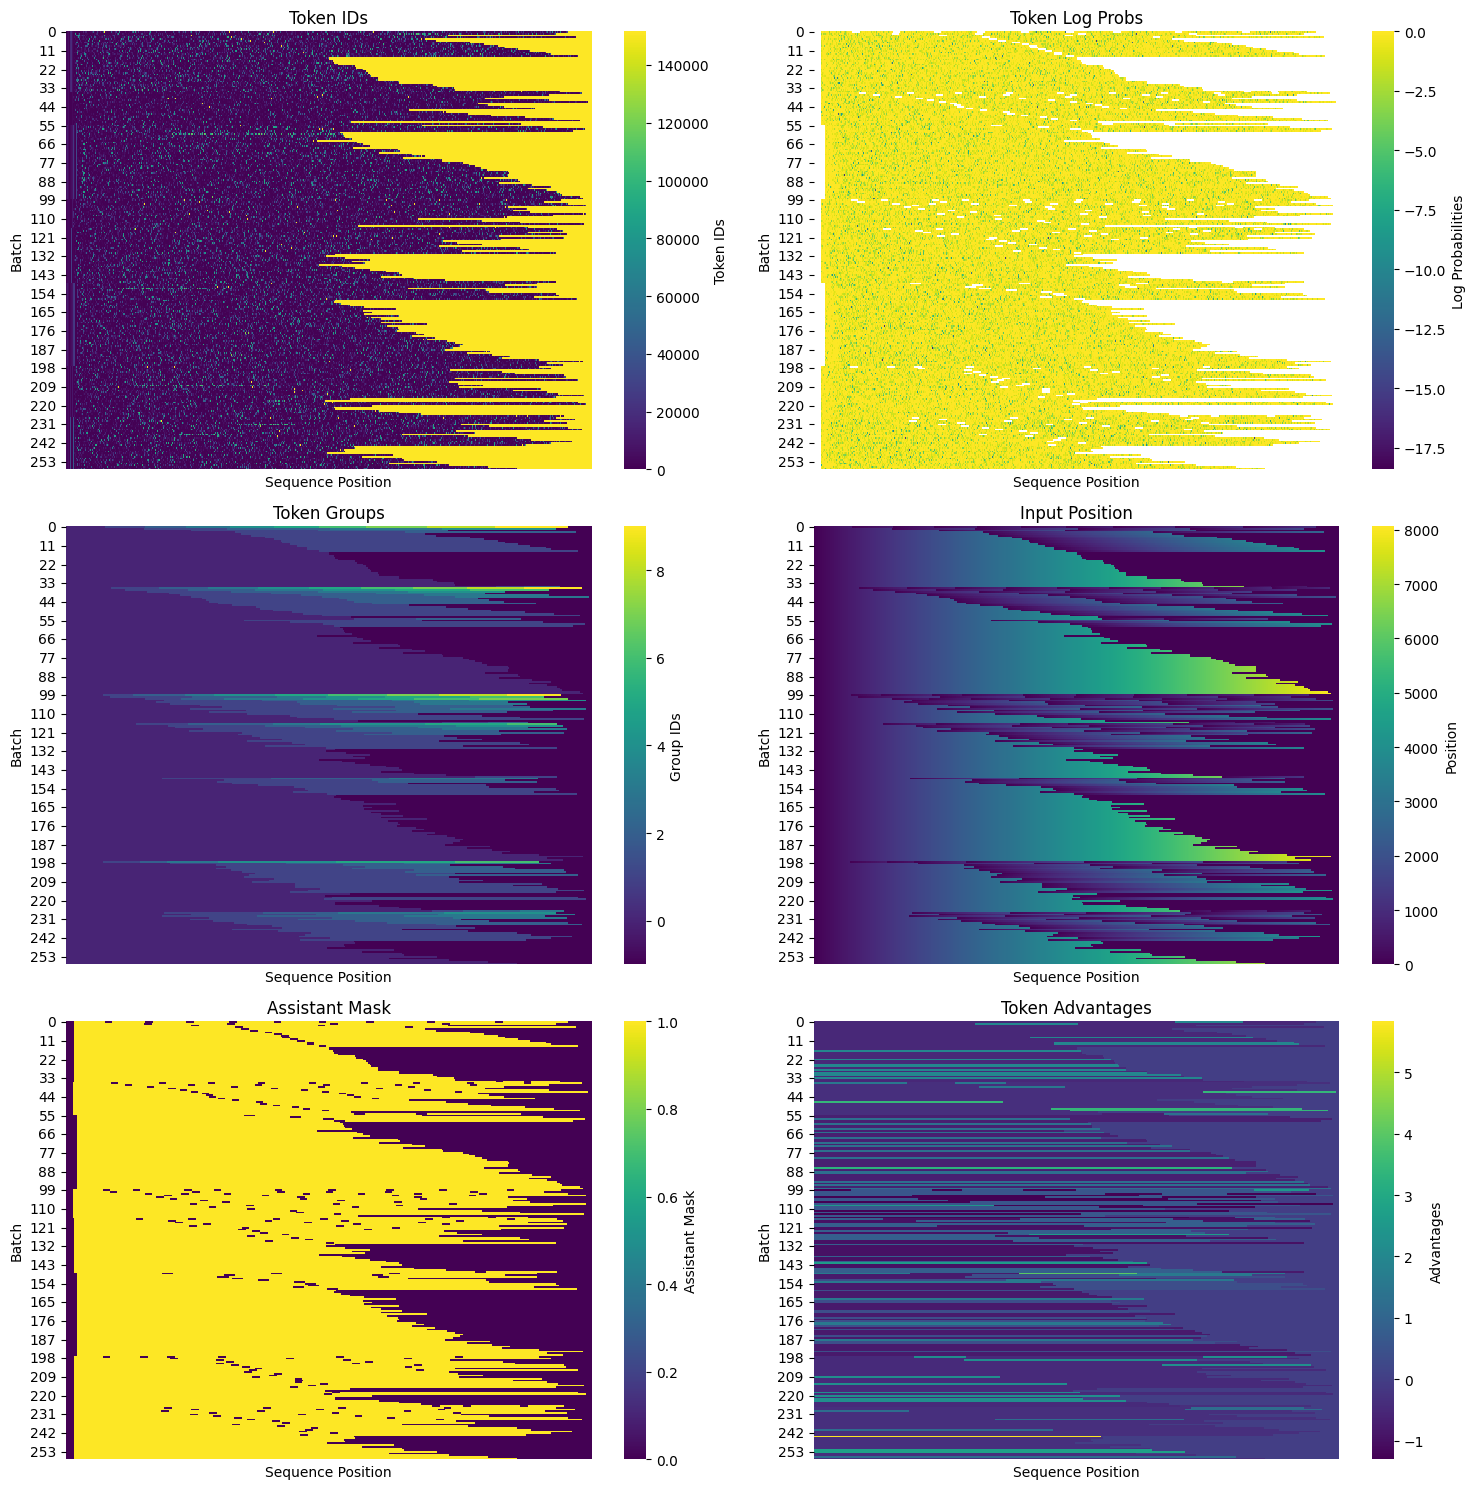

Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/blobs/a6344aac8c09253b3b630fb776ae94478aa0275b
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/blobs/d42fae903e9fa07f3e8edb0db00a8d905ba49560
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/blobs/d6ff9c6d4933688f95f315e3ce08f8e5e28eaeee
Download complete. Moving file to /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/blobs/d1fd67ec1bf748c24b244b6efd825ded1b147787
$ tune run --nproc-per-node=4 lib.recipe.TuneRecipe --config ./models/014/config.yaml
Running with torchrun...


W0219 16:21:09.500000 17139 torch/distributed/run.py:793] 
W0219 16:21:09.500000 17139 torch/distributed/run.py:793] *****************************************
W0219 16:21:09.500000 17139 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 16:21:09.500000 17139 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 8
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/gcpuser/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-32B/snapshots/3865e12a1eb7

Writing logs to models/014/logs/log_1739982074.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 57.95 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 9.81 GiB
	GPU peak memory reserved: 10.04 GiB
	GPU peak memory active: 9.81 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/8 [00:00<?, ?it/s][rank3]: Traceback (most recent call last):
[rank3]:   File "<frozen runpy>", line 198, in _run_module_as_main
[rank3]:   File "<frozen runpy>", line 88, in _run_code
[rank3]:   File "/home/gcpuser/sky_workdir/experiments/lib/recipe.py", line 1322, in <module>
[rank3]:     sys.exit(config.parse(recipe_main)())  # type: ignore
[rank3]:   

AssertionError: No model checkpoint files found to save in output directory ./models/014

In [7]:
for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=512,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=512,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.2 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = round(wandb_data["tokens"])
    vllm.process.terminate()
    kill_vllm_workers()
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, get_iteration(output_dir) - 1])
    except Exception:
        pass
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
    raise
wandb.finish()